In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

In [3]:
# Tensorflow
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

In [4]:
from pathlib import Path
import os.path

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [6]:
import wget

# Downloading the helper_functions.py file from the GitHub repository
wget.download("https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py", "helper_functions.py")

# Importing the necessary functions from the downloaded script
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot


100% [..........................................................] 10246 / 10246

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = (320, 320)

In [8]:
# Checking all directories
dataset = "/Users/vishalbhatia/Documents/MSc. Data Science and AI/PROJECTS/MINOR PROJECTS/Fire image calssification/fire_dataset"
walk_through_dir(dataset)

There are 2 directories and 0 images in '/Users/vishalbhatia/Documents/MSc. Data Science and AI/PROJECTS/MINOR PROJECTS/Fire image calssification/fire_dataset'.
There are 0 directories and 244 images in '/Users/vishalbhatia/Documents/MSc. Data Science and AI/PROJECTS/MINOR PROJECTS/Fire image calssification/fire_dataset/non_fire_images'.
There are 0 directories and 755 images in '/Users/vishalbhatia/Documents/MSc. Data Science and AI/PROJECTS/MINOR PROJECTS/Fire image calssification/fire_dataset/fire_images'.


In [9]:
image_dir = Path(dataset)

# Getting filepaths : Taking all possibilities (.JPG / .jpg / .png)
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

# Getting Labels
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [10]:
print('Length of our data set : ' , len(list(image_dir.glob(r'**/*.png'))))
print('Labels : ' , labels )

Length of our data set :  999
Labels :  0      non_fire_images
1      non_fire_images
2      non_fire_images
3      non_fire_images
4      non_fire_images
            ...       
994        fire_images
995        fire_images
996        fire_images
997        fire_images
998        fire_images
Name: Label, Length: 999, dtype: object


In [11]:
image_df

Filepath            Label
0    /Users/vishalbhatia/Documents/MSc. Data Scienc...  non_fire_images
1    /Users/vishalbhatia/Documents/MSc. Data Scienc...  non_fire_images
2    /Users/vishalbhatia/Documents/MSc. Data Scienc...  non_fire_images
3    /Users/vishalbhatia/Documents/MSc. Data Scienc...  non_fire_images
4    /Users/vishalbhatia/Documents/MSc. Data Scienc...  non_fire_images
..                                                 ...              ...
994  /Users/vishalbhatia/Documents/MSc. Data Scienc...      fire_images
995  /Users/vishalbhatia/Documents/MSc. Data Scienc...      fire_images
996  /Users/vishalbhatia/Documents/MSc. Data Scienc...      fire_images
997  /Users/vishalbhatia/Documents/MSc. Data Scienc...      fire_images
998  /Users/vishalbhatia/Documents/MSc. Data Scienc...      fire_images

[999 rows x 2 columns]

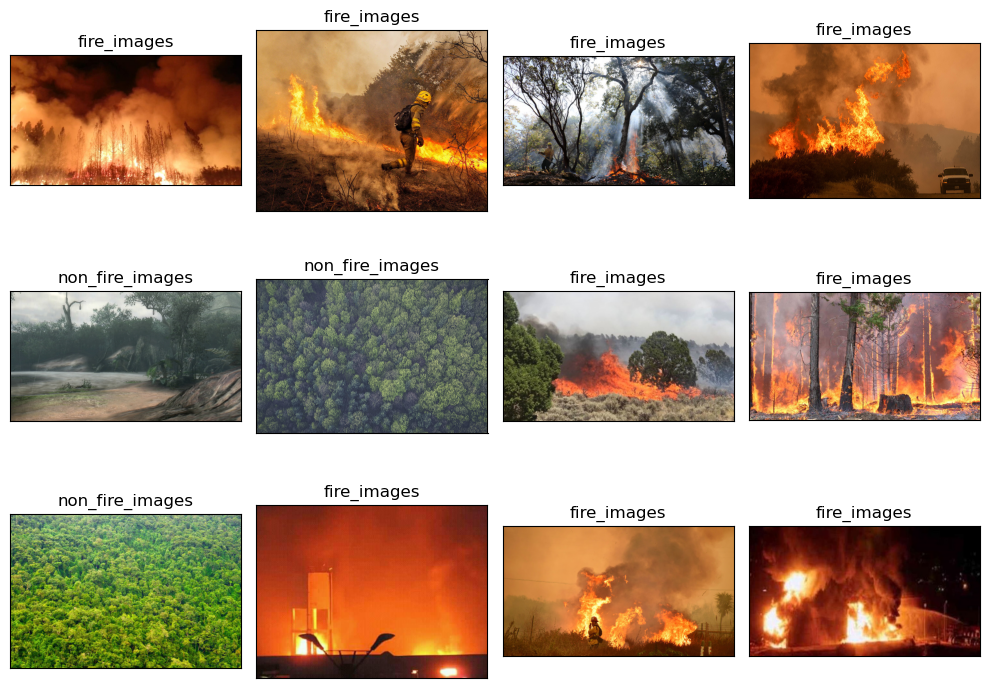

In [12]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Assuming 'image_df' is a DataFrame with 'Filepath' and 'Label' columns
# Display 12 pictures of the dataset with their labels

# Generate 12 random indices
random_indices = np.random.randint(0, len(image_df), 12)

# Create a figure with 3 rows and 4 columns to display 12 images
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7.5),  # Adjust the figure size as needed
                         subplot_kw={'xticks': [], 'yticks': []})

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, ax in enumerate(axes):
    # Open the image from the random index
    image = Image.open(image_df.Filepath[random_indices[i]])
    
    # Display the image
    ax.imshow(image)
    
    # Set the title of the subplot to the corresponding label
    ax.set_title(image_df.Label[random_indices[i]])
    
    # Hide x and y axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust the layout so there's no overlap
plt.tight_layout()

# Display the plot
plt.show()


In [13]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [14]:
# Creating a data generator for the training set
train_generator = ImageDataGenerator(
    # This function pre-processes each image like MobileNetV2 was trained on
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    # Reserving 20% of the training data for validation
    validation_split=0.2
)

# Creating a data generator for the testing set
test_generator = ImageDataGenerator(
    # Using the same pre-processing function for consistency
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [15]:
# Taking the traing images.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 640 validated image filenames belonging to 2 classes.


In [16]:
# Taking the validation images.
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 159 validated image filenames belonging to 2 classes.


In [17]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 200 validated image filenames belonging to 2 classes.


In [18]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

2024-04-04 20:24:02.916399: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-04 20:24:02.916442: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-04 20:24:02.916456: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-04 20:24:02.916909: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-04 20:24:02.917296: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [20]:
# Import the ModelCheckpoint callback from Keras
from tensorflow.keras.callbacks import ModelCheckpoint

# Set the path where the checkpoints will be saved
checkpoint_path = "fires_classification_model_checkpoint"

# Initialize the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,  # Designates the directory where checkpoints are saved
    save_weights_only=True,    # Indicates that we're only saving the weights of the model
    monitor='val_accuracy',    # Specifies that the validation accuracy is the metric to monitor
    save_best_only=True        # Ensures that only the best version of the model is saved
)

# Now, this 'checkpoint_callback' can be passed to the 'fit' method of the model to ensure
# that during training, only the best model's weights are saved whenever 'val_accuracy' improves.


In [21]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor the validation loss metric
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the lowest validation loss
)


In [22]:
# Start by defining the model input from the pre-trained base model
inputs = pretrained_model.input

# Next, apply pre-defined resizing and rescaling layers to the input data
x = resize_and_rescale(inputs)

# Extend the pre-trained model by adding new fully connected layers
# First, add a dense layer with ReLU activation
x = Dense(256, activation='relu')(pretrained_model.output)
# Introduce dropout for regularization to prevent overfitting
x = Dropout(0.2)(x)
# Repeat the dense layer and dropout pattern
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

# Finalize the model with an output layer using softmax for binary classification
outputs = Dense(2, activation='softmax')(x)

# Create the model object by specifying inputs and outputs
model = Model(inputs=inputs, outputs=outputs)

# Compile the model, setting up the optimizer, loss function, and metrics for evaluation
model.compile(
    optimizer=Adam(0.0001),  # Use Adam optimizer with a small learning rate for fine-tuning
    loss='categorical_crossentropy',  # Use categorical crossentropy for loss calculation
    metrics=['accuracy']  # Track accuracy during training
)

# Prepare the model for training by setting up the datasets, number of steps, and callbacks
history = model.fit(
    train_images,  # Specify the training data
    steps_per_epoch=len(train_images),  # Set the number of steps per epoch equal to the size of training data
    validation_data=val_images,  # Provide validation data for performance evaluation
    validation_steps=len(val_images),  # Set the number of validation steps equal to the size of validation data
    epochs=100,  # Define the number of epochs for training
    callbacks=[  # Include a list of callbacks for various training utilities
        early_stopping,  # Stop training early if no improvement in validation loss for a set number of epochs
        create_tensorboard_callback("training_logs", "fire_classification"),  # Log training data for visualization in TensorBoard
        checkpoint_callback,  # Save the model after epochs where performance has improved
    ]
)


Saving TensorBoard log files to: training_logs/fire_classification/20240404-202418
Epoch 1/100


2024-04-04 20:24:20.777345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 0.4845 - accuracy: 0.7844

2024-04-04 20:24:33.677764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 16s 591ms/step - loss: 0.4845 - accuracy: 0.7844 - val_loss: 0.1381 - val_accuracy: 0.9497
Epoch 2/100
20/20 [==============================] - 11s 543ms/step - loss: 0.1800 - accuracy: 0.9406 - val_loss: 0.0802 - val_accuracy: 0.9560
Epoch 3/100
20/20 [==============================] - 11s 541ms/step - loss: 0.1192 - accuracy: 0.9563 - val_loss: 0.0531 - val_accuracy: 0.9811
Epoch 4/100
20/20 [==============================] - 11s 544ms/step - loss: 0.0877 - accuracy: 0.9750 - val_loss: 0.0465 - val_accuracy: 0.9874
Epoch 5/100
20/20 [==============================] - 11s 544ms/step - loss: 0.0909 - accuracy: 0.9734 - val_loss: 0.0385 - val_accuracy: 0.9937
Epoch 6/100
20/20 [==============================] - 10s 532ms/step - loss: 0.0768 - accuracy: 0.9766 - val_loss: 0.0396 - val_accuracy: 0.9874
Epoch 7/100
20/20 [==============================] - 11s 542ms/step - loss: 0.0664 - accuracy: 0.9766 - val_loss: 0.0322 - val_accuracy: 1.0000
Epoc

In [23]:
# Evaluate the model on the test set and store the loss and accuracy in 'test_results'
test_results = model.evaluate(test_images, verbose=0)

# Display the loss and accuracy in a formatted message
test_loss = test_results[0]
test_accuracy = test_results[1] * 100
print(f"Test Loss: {test_loss:.5f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.06968
Test Accuracy: 97.50%


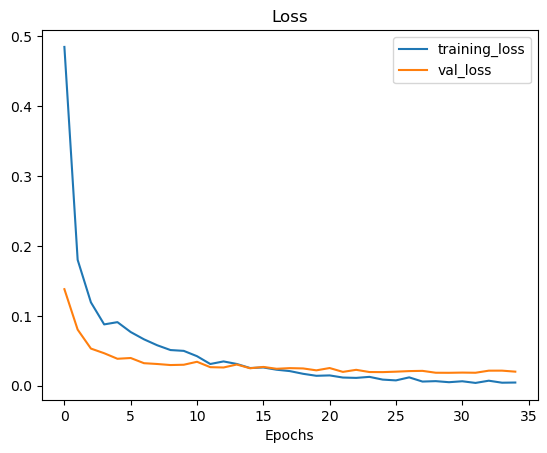

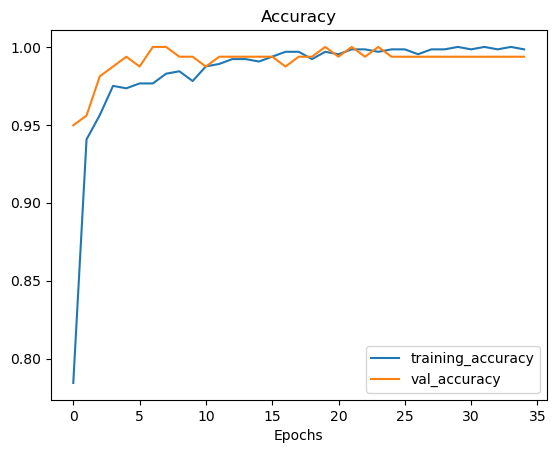

In [24]:
plot_loss_curves(history)

In [25]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

2024-04-04 20:31:12.905864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 3s 413ms/step
The first 10 predictions: ['fire_images', 'fire_images', 'non_fire_images', 'fire_images', 'fire_images', 'fire_images', 'fire_images', 'fire_images', 'fire_images', 'fire_images']


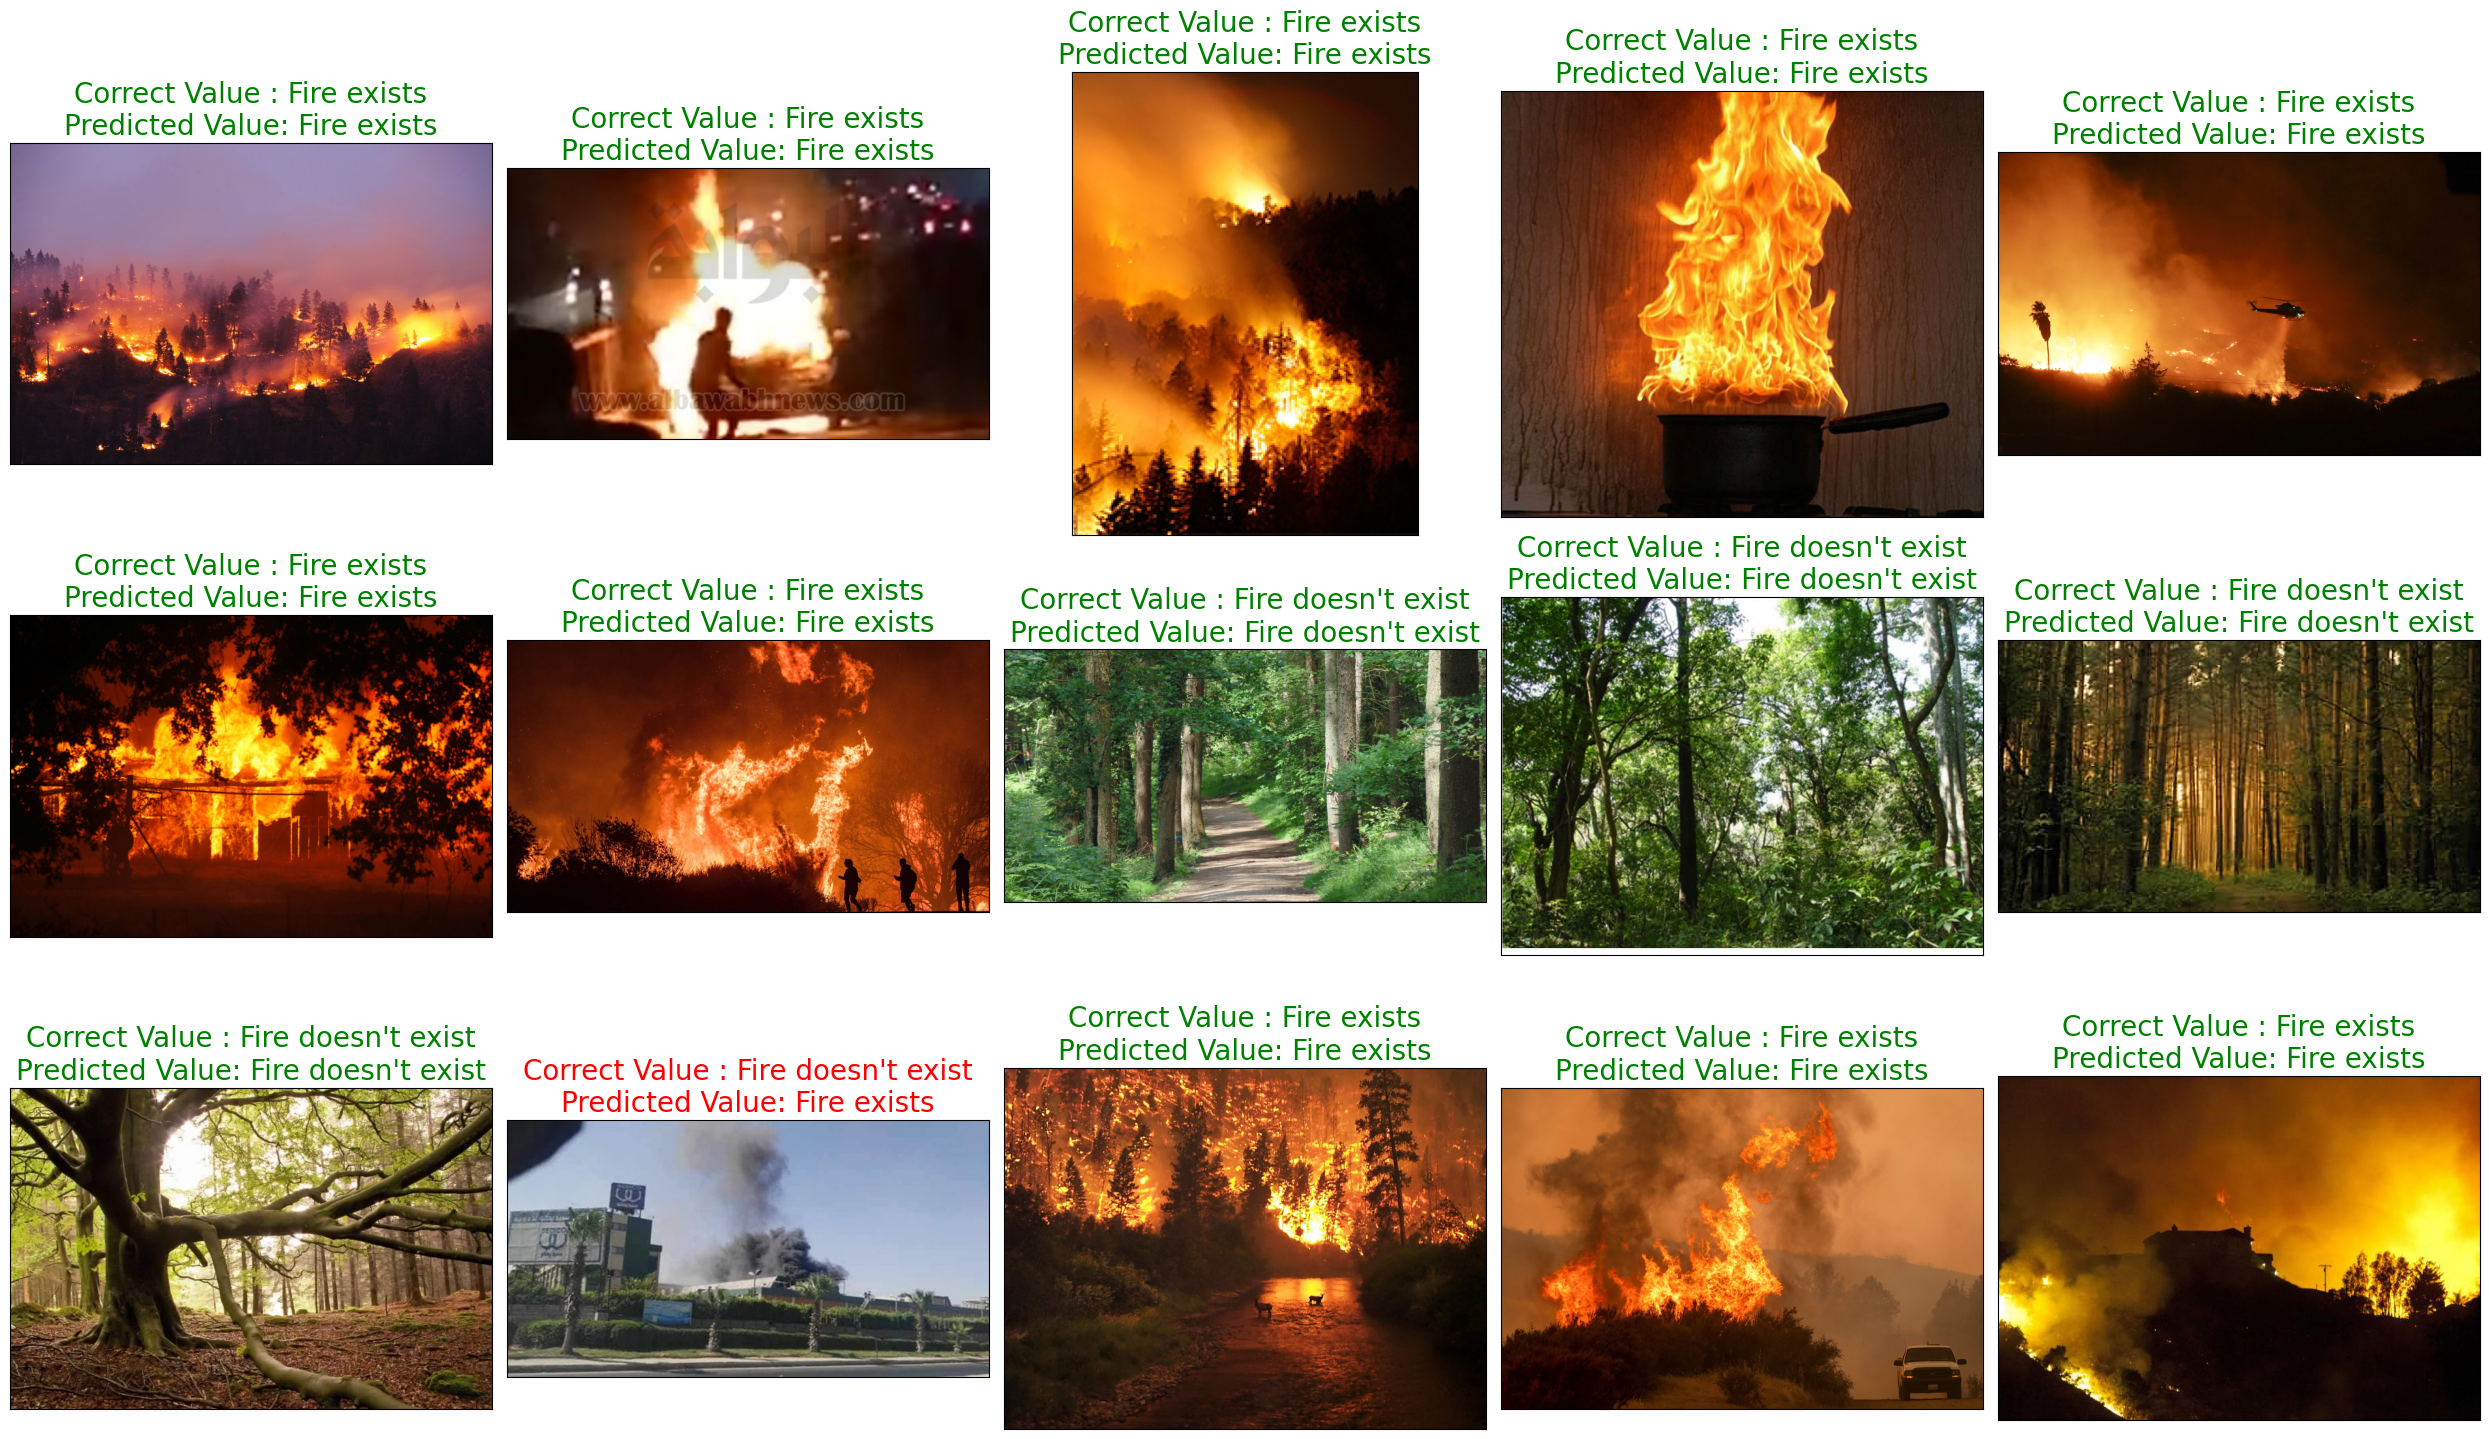

In [26]:
# Display 15 random pictures from the dataset with their labels
random_indices = np.random.randint(0, len(test_df), 15)
fig, axes = plt.subplots(3, 5, figsize=(25, 15))  # Grid of 3x5 for the images

# Set a larger font size for the image titles
title_fontsize = 20

# Iterate over the axes and the random indices in parallel
for ax, idx in zip(axes.flat, random_indices):
    img_path = test_df.iloc[idx]['Filepath']
    true_label = test_df.iloc[idx]['Label']
    predicted_label = pred[idx]
    
    img = Image.open(img_path)
    ax.imshow(img)

    # Set the title color based on prediction accuracy
    title_color = 'green' if true_label == predicted_label else 'red'
    true_label_text = "Fire exists" if true_label == "fire_images" else "Fire doesn't exist"
    predicted_label_text = "Fire exists" if predicted_label == "fire_images" else "Fire doesn't exist"
 
    ax.set_title(f"Correct Value : {true_label_text}\nPredicted Value: {predicted_label_text}",
                 color=title_color, fontsize=title_fontsize)

    # Remove axis ticks for a cleaner look
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [27]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

    fire_images       0.98      0.99      0.98       158
non_fire_images       0.97      0.90      0.94        42

       accuracy                           0.97       200
      macro avg       0.97      0.95      0.96       200
   weighted avg       0.97      0.97      0.97       200



In [28]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score  support
fire_images       0.975155  0.993671  0.984326  158.000
non_fire_images   0.974359  0.904762  0.938272   42.000
accuracy          0.975000  0.975000  0.975000    0.975
macro avg         0.974757  0.949216  0.961299  200.000
weighted avg      0.974988  0.975000  0.974655  200.000

In [29]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
   
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Reds) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted Value",
         ylabel="Correct Value",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


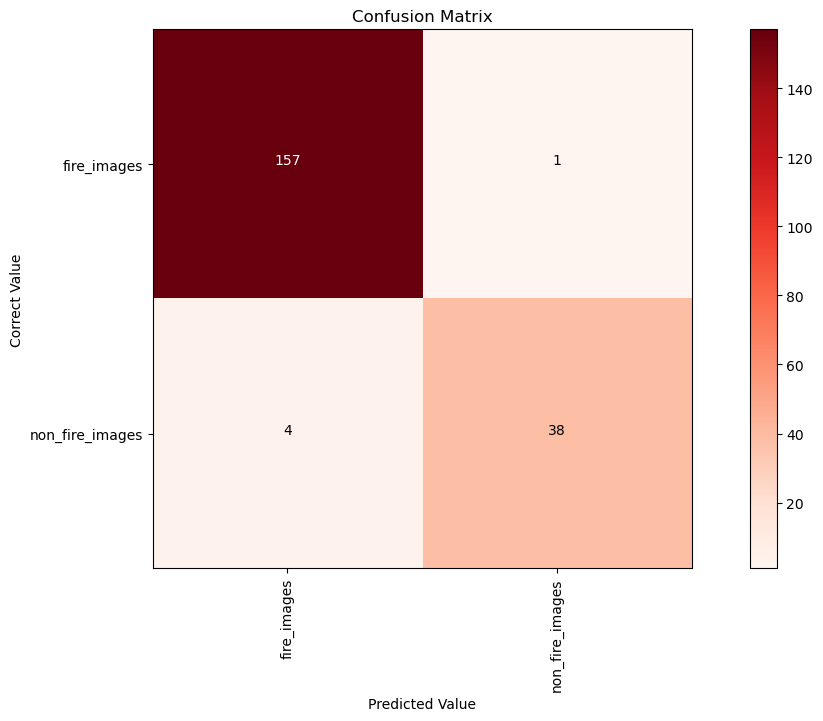

In [30]:
make_confusion_matrix(y_test, pred, list(labels.values()))